In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
import ugradio

mpl.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


# Load in Raw Data

In [2]:
sun_data = np.load("1hr_Sun_data.npy")
data = np.array([sun_data[1,:], sun_data[0,:]])
data = data[:,100:]

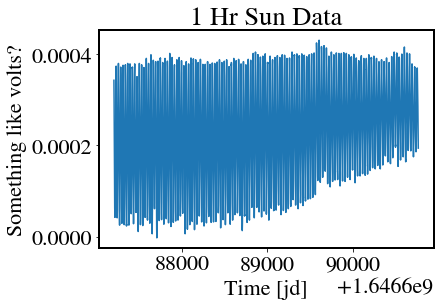

In [3]:
plt.plot(data[0], data[1])
plt.title("1 Hr Sun Data")
plt.xlabel("Time [jd]")
plt.ylabel("Something like volts?")
plt.show()

## $\chi^2$ Analysis

This is an argument inside the next equation. It depends on a whole bunch of stuff $(B_{ew}, B_{ns}, \delta, h_s)$ which we will define in the cell below. We are most interested in $B_{ew}, B_{ns}$, the frequency of the trig functions is

$$\nu \tau_g'(B_{ew}, B_{ns}, \delta, h_s) = \left[{B_{ew} \over \lambda} \cos \delta \right] \sin h_s 
  + \left[{B_{ns} \over \lambda} \sin L \cos \delta \right] \cos h_s$$


We need to explore parameter space by making a grid of $B_{ew}, B_{ns}$ and curve fitting at each combo to yield a $\chi^2$ value for each combination. We will be fitting for $A,B$ but we don't care about those at all. This will allow us to fit the fringe amplitude. As long as we stay within 1 bessel envelope node we should be fine, so the 1 hour data should be just fine.

$$F(h_s) = A \cos \left(2 \pi \nu \tau_g' \right) 
         +B \sin \left(2 \pi \nu \tau_g' \right)$$
         
 

In [14]:
ugradio.timing.lst??

In [283]:
import astropy.constants as con
import astropy.units as u

val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.77 / 100 # 2.77 cm

jds=ugradio.timing.julian_date(data[0])
α,δ =ugradio.coord.sunpos(jds[0])
δ=(np.pi/180)*δ

LSTs = ugradio.timing.lst(jds,lon=long) #feed in an array of julian dates observed.
δ

-0.08984477772374938

In [284]:
LSTs

array([6.28302026, 6.28303486, 6.28304946, ..., 0.25969693, 0.2597116 ,
       0.25972613])

In [285]:
h_s = LSTs-α*(np.pi/180) #create array of hour angles

#in the mean time we create h_s just by a linspace


In [286]:
h_s=np.linspace(11.02,(11.02+15),len(jds))*(np.pi/180)

In [287]:
h_s

array([0.19233528, 0.19234996, 0.19236463, ..., 0.45410532, 0.45412   ,
       0.45413467])

In [288]:
#model functions
def ν_τg(h_s, B_ew, B_ns, δ, λ):
    return (((B_ew / λ) * np.cos(δ)) * np.sin(h_s) + ((B_ns / λ) * np.sin(L) * np.cos(δ)) * np.cos(h_s))

def fringe_model(ν_τg, A, B):
    return A * np.cos(2 * np.pi * ν_τg) + B * np.sin(2 * np.pi * ν_τg)
    

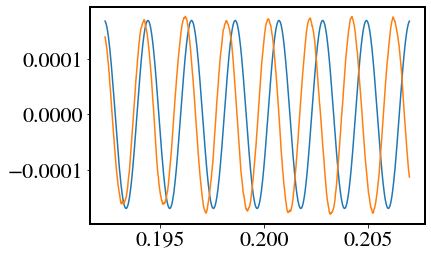

In [289]:
v = ν_τg(h_s[:1000], 14, 3, δ, λ)

plt.plot(h_s[:1000], fringe_model(v, 0.00012, 0.00012))
plt.plot(h_s[:1000],data[1][:1000]-np.mean(data[1][:1000]))
plt.show()

In [299]:
#create grid of baseline values
resolution = 100
xmin,xmax = 14.4,14.9
ymin,ymax = 0.1,5
B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
B_EW, B_NS = np.meshgrid(B_ew, B_ns)

### Compute $\chi^2$

Note: this is SLOW, reduce resolution to speed up

In [300]:
ydata = data[1] - np.mean(data[1])

χ_sq = np.zeros(B_EW.shape)
for i in range(len(B_ew)):
    for j in range(len(B_ns)):
        vs = ν_τg(h_s, B_EW[i,j], B_NS[i,j], δ, λ)  # Try new baselines
        p0 = np.array([0.0002,0.0003]) # A, B Guesses
        params, cov = scipy.optimize.curve_fit(fringe_model, vs, ydata, p0)
        chi_squared = np.sum(((fringe_model(vs, *params)-ydata)/.00001)**2)
        reduced_chi_squared = (chi_squared)/(len(vs)-len(params))
        χ_sq[i,j] = chi_squared


### Plot!

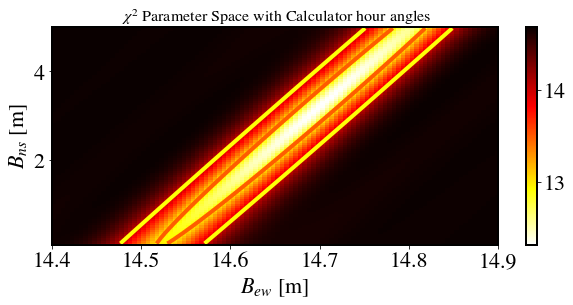

In [322]:
extent=[xmin, xmax, ymin, ymax]
levels = [11, 12, 13, 14, 15]
plt.figure(figsize=(10,4))
plt.title(" $\chi^2$ Parameter Space with Calculator hour angles",fontsize=16)

plt.contour(np.log(χ_sq), levels, cmap="hot", origin='lower',linewidths=4, extent=extent)
plt.imshow(np.log(χ_sq), origin="lower",extent=extent, cmap="hot_r", aspect="auto")
plt.xlabel("$B_{ew}$ [m]")
plt.ylabel("$B_{ns}$ [m]")
#plt.ylim(0,1)
#plt.xlim(12,20)
plt.colorbar()

plt.show()

In [224]:
print(χ_sq.shape)

(40, 40)


In [282]:
λ

0.0028551662666666667